In [1]:
import matplotlib
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, h5py as h5
from matplotlib.cm import rainbow
from PreFRBLE.convenience import *
from PreFRBLE.likelihood import *
from PreFRBLE.physics import *
from PreFRBLE.plot import *


# Rodrigues model for host and intervening galaxies (Rodrigues et al. 2018)


Rodrigues et al. provide a set of axisymmetric galaxy ensembles, obtained via GALFORM, which represent the population of galaxies in the Universe according to galaxy formation theory.
From these, we obtain the expected contribution to DM, RM and SM of FRBs via a Monte-Carlo simulation, probing LoS with random geometry through random galaxy models.
Here we translate the output of the Monte-Carlo simulation performed with magnetizer code by Luiz F. S. Rodrigues to format used in PrEFRBLE.
These results are given for different redshift bins than used in PrEFRBLE.
We obtain the likelihood functions used in PrEFRBLE by redshifting the results of the nearest neighbour redshift.

In [4]:
## model nmnemonic
model = 'Rodrigues18'

## file containing raw data
Rodrigues_datafile = '../../likelihood/Rodrigues_galaxy_raw.h5'

## file to contain average r_gal and n_gal
Rodrigues_file_rgal = '../../likelihood/Rodrigues_galaxy_radius.dat'


## number of redshift bins and bins in likelihood functions
N_z, N_bins = 60, 100  

## redshift bins in PreFRBLE
zs0 = redshift_bins
h = 0.703


In [5]:
def NearestNeighbor( x=1., xs=np.array([0.,1.,2.]) ):
    """ find nearst neighbor of x in xs """
    #print( np.diff( xs, axis=1, prepend=x) )
    dx = (xs - x)**2
    i_NN = np.where( dx == dx.min() )[0][0]
    return i_NN

def NearestNeighbors( x=1., xs=np.array([0.,1.,2.]) ):
    """ find nearst neighbors of x in xs """
    try:
        i_NN = np.where( xs >= x )[0][0]
    except:
        return np.array([-1])
    return np.array([-1,0]) + i_NN


def  LikelihoodStandardize( P=[], x=[], redshift=0.0, measure='DM' ):
    """ transform raw data format to standard format in PrEFRBLE """
        
    ## translate logarithmic bin central points to bin ranges
    dx = np.mean(np.diff(x))
    x = 10.**np.append( x[0]-dx/2, x+dx/2 )

    ## raw data is normalized to 1 = sum( P * diff( log10(DM) ) ), renormalize to 1 = sum( P * diff(DM) )
    P *= np.diff( np.log10(x) ) / np.diff( x )
    P /= np.sum( P*np.diff(x)) ## make it exact
                
    ## transform to proper values (data is written in residual frame)
    P, x = LikelihoodShift( x=x, P=P, shift=(1+redshift)**-scale_factor_exponent[measure] )
    
    ## use correct number of bins
    P, x = LikelihoodShrink( P=P, x=x, bins=N_bins )
    
    return P, x

### plot galaxy stellar mass function and $n_{\rm gal}(>M)$
and put correct $n_{\rm gal}$ from GSMF in Rodrigues_datafile

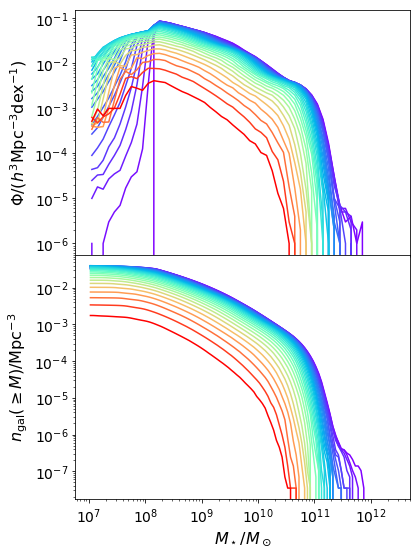

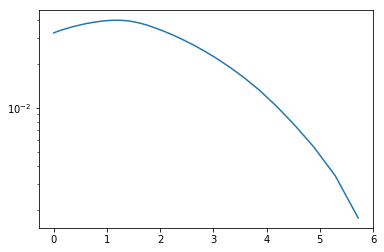

In [6]:
source = '../../../PreFRBLE_2nd/data/galaxy_data.hdf5'
fig, axs = plt.subplots(2,1, figsize=(6,9), sharex='all')

## parameters used by Rodrigues18
bin_width = 0.1
subvol = 500**3/512 ## Mpc^3 h^-3
N_subvol = 41
volume = subvol*N_subvol ## Mpc^3 h^-3


ns = []
with h5.File(source, 'r') as f:
    ## only for z=0
    zs = list(f.keys())
    zs_float = np.array(zs).astype('f')
    colors = list(Rainbow(zs_float))[::-1]
#    colors = ['blue']
    for z in zs[:]:
        
        GSMF = f[z]['GSMF']['data'][()]  ## log10( h^3 Mpc^-3 dex^1 comoving )
        M = f[z]['GSMF']['bins'][()]
        bin_width = M[1]-M[0] ## log10( M_sun )
        GSMF = 10.**GSMF  ## h^3 Mpc^-3 dex^1 comoving
        M = 10.**M ## M_sun

        color=colors.pop()
        axs[0].loglog(M, GSMF, color=color)

#        GDMF = np.cumsum( bin_width* GSMF[::-1])[::-1]
        
        GDMF = f[z]['cumGSMF']['data'][()] ## N_galaxies
        Mmin = f[z]['cumGSMF']['bins'][()] ## log10( M_sun )
        
        GDMF /= volume ## ## h^3 Mpc^-3 comoving
        GDMF *= h**3 ## Mpc^-3 comoving
#        GDMF *= (1+float(z))**3 ## Mpc^-3
        Mmin = 10.** Mmin ## M_sun
        
        axs[1].loglog( Mmin, GDMF, color=color, ls='-')
        
        n = GDMF[0] ## Mpc^-3 comoving
#        n *= (1+float(z))**3 ## to Mpc^-3, as indicated in the file
        ns.append(n)
        
        ## write n to Rodrigues_datafile
        with h5.File(Rodrigues_datafile,'a') as ff:
            ff[z]['number_density'][()] = n

        
    
    axs[0].set_ylabel(r"$\Phi /  ( h^3 {\rm Mpc}^{-3} {\rm dex}^{-1})$", fontsize=16 )
    axs[1].set_ylabel(r"$n_{\rm gal} (\geq M)/  {\rm Mpc}^{-3}$", fontsize=16 )
    axs[1].set_xlabel(r"$M_\star/ M_\odot$", fontsize=16 )
#    axs[1].set_yscale('linear')
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=14)

    plt.subplots_adjust(hspace=0.0)
#    Colorbar(x=zs_float, label='redshift')
plt.show()

plt.plot(zs_float, ns)
#plt.plot(zs_float, ns*(1+zs_float)**-3)
plt.yscale('log')

### Standardize Likelihood
Here we read the raw simulation output (*Rodrigues_datafile*) and transform to the standards used in PrEFRBLE (*likelihood_file_galaxy*), i. e. number of bins in P, renormalization and redshift bins. Also saves average half-mass radius and number density of galaxies as function of redshift (*Rodrigues_file_rgal*).

In [8]:
n_gals, r_gals = [], []

with h5.File(Rodrigues_datafile,'r') as f:
    
    ## redshift bins of raw results
    zs = list(f.keys())
    zs_float = np.array(zs).astype('float')
    colors = list(Rainbow(zs0))
    for z0, c in zip(zs0, colors):
#    for z0, c in zip([0.], colors):

        ## find nearst neighbour redshift
        iz = NearestNeighbor( x=z0, xs=zs_float )
        
        izs = NearestNeighbors( x=z0, xs=zs_float )
        ## linear approximation
        weights = 1 - np.abs( zs_float[izs] - z0 )/np.diff(zs_float[izs])
        # quadratic approximation
#        weights = 1 - (np.abs( zs_float[izs] - z0 )/np.diff(zs_float[izs]))**2
        if izs[0] == [-1]:
            weights = [1]
    
        
        ## first, prepare correct redshift binning of r_gal and n_gal
        '''
        ### read raw data of nearest neighbour
        r_gal = f['/'.join([zs[iz],"avg_radius"])][()]  ## proper
        n_gal = f['/'.join([zs[iz],"number_density"])][()]  ## comoving
        print( f['/'.join([zs[iz],"volume"])][()] )
        '''
        ## instead of nearest neighbour, use approximation between nearest neighbours
        r_gal = np.sum( [ w*f['/'.join([zs[iz],"avg_radius"])][()] for iz, w in zip(izs, weights)] )  ## kpc
        n_gal = np.sum( [ w*f['/'.join([zs[iz],"number_density"])][()] for iz, w in zip(izs, weights)] )  ## Mpc^-3 comoving
        #'''
        n_gal *= (1+z0)**3 ## Mpc^-3
        
        n_gals.append(n_gal) 
        r_gals.append(r_gal)
        

        
#        """        
        for measure in ['DM','RM','SM'][1:]:
            for host in [True,False]:
                '''
                ## read raw data of nearest neighbour
                x = f['/'.join([zs[iz],"FRB_{}".format(measure) if host else measure])]['bins'][()]
                P = f['/'.join([zs[iz],"FRB_{}".format(measure) if host else measure])]['data'][()]
                
                ## bring to standard form used in PrEFRBLE
                P, x = LikelihoodStandardize( P=P, x=x, redshift=z0, measure=measure)
                '''
                ## instead of nearest neighbour, use approximation between nearest neighbours
                
                ## read raw data of nearest neighbours
                Ps, xs = [], []
                for iz in izs:
                    x = f['/'.join([zs[iz],"FRB_{}".format(measure) if host else measure])]['bins'][()] 
                    P = f['/'.join([zs[iz],"FRB_{}".format(measure) if host else measure])]['data'][()] 
                    
                    ## bring to standard form used in PrEFRBLE
                    P, x = LikelihoodStandardize( P=P, x=x, redshift=z0, measure=measure)
                    Ps.append(P)
                    xs.append(x)

                P, x = LikelihoodsAdd( Ps=Ps, xs=xs, log=True, weights=weights, renormalize=1)
                #'''
                
                ## write to file
                if host:
                    keys = [ KeyHost( model=model, redshift=z0, measure=measure, axis=axis ) for axis in ['P','x'] ]
                else:
                    keys = [ Keyinter( model=model, redshift=z0, measure=measure, axis=axis ) for axis in ['P','x'] ]
                Write2h5( likelihood_file_galaxy, datas=[P,x], keys=keys )
        
#        PlotLikelihood( x, P, measure=measure, ax=ax, color=c, alpha=0.5, density=True )
#        plt.xscale('log')
#        plt.yscale('linear')
#        print( 'density?',sum(P*np.diff(x)) )
        #break
#Colorbar( x=zs0, ax=ax,  )
#        """
with open( Rodrigues_file_rgal, 'w' ) as f:
    f.write( 'redshift\tr_gal\tn_gal\n' )
    for z, r, n in zip( zs0, r_gals, n_gals):
        f.write( "{0}\t{1}\t{2}\n".format(z,r, n) )

In [71]:
NInter(2.0)

0.1095980884890292

### plot redshift evolution of $n_{\rm gal}$ and $r_{\rm gal}$

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:13: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  del sys.path[0]


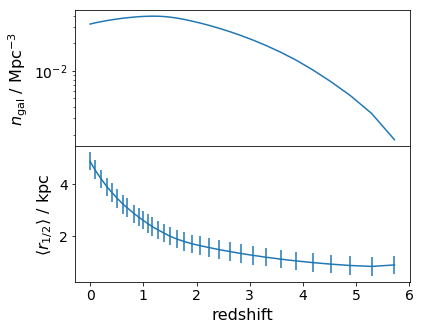

In [80]:
files = ['../../../PreFRBLE_2nd/data/galaxy_data_centrals.hdf5','../../../PreFRBLE_2nd/data/galaxy_data.hdf5']
h = 0.703

files= [Rodrigues_datafile]

fig, axs = plt.subplots( 2, 1, figsize=(6,5), sharex='all' )

for fn in files[:]:
    zs = []
    ns= []
    rs = []
    r_devs = []
    with h5.File(fn) as f:
#with h5.File('../../../PreFRBLE_2nd/data/galaxy_data.hdf5') as f:
        for k in f.keys():
            n=f[k+'/number_density'][()]
            r=f[k+'/avg_radius'][()]
            r_dev = f[k+'/std_radius'][()]
#            r=np.sqrt(f[k+'/avg_radius_squared'][()])
#            r_dev = f[k+'/std_radius_squared'][()]
            z = float(k)
            zs.append(z)
            ns.append(n) #*(1+z)**3)
#            ns.append(n*h**3)
            rs.append(r)
            r_devs.append(r_dev)
    axs[0].plot(zs,ns)
    axs[1].errorbar(zs,rs, yerr=r_dev)
axs[0].set_yscale('log')
#plt.plot(z_gal, n_gal)
axs[0].set_ylabel(r"$n_{\rm gal}$ / Mpc$^{-3}$", fontsize=16)
axs[1].set_ylabel(r"$\langle r_{1/2}\rangle$ / kpc", fontsize=16)
axs[1].set_xlabel('redshift', fontsize=16)
axs[0].set_yscale('log')
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=14)
plt.subplots_adjust(hspace=0.0)

In [98]:
z=2.7
NInter(z,), NInter(z, model='Macquart13')

(0.12368978315961195, 0.1261949169205686)

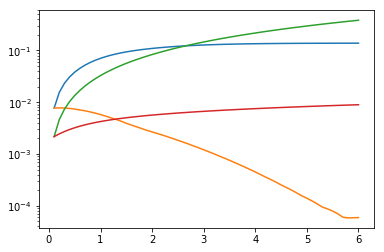

In [102]:
n_inter = nInter( model='Rodrigues18')
N_inter = np.cumsum(n_inter)
plt.plot(zs0, N_inter)
plt.plot(zs0, n_inter)

n_inter = nInter( model='Macquart13')
N_inter = np.cumsum(n_inter)
plt.plot(zs0, N_inter)
plt.plot(zs0, n_inter)
plt.yscale('log')



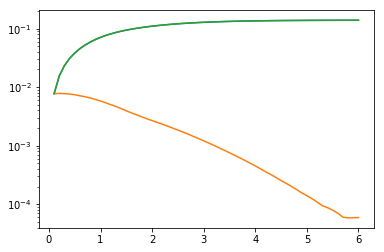

StopIteration: 

In [81]:
d = np.genfromtxt(Rodrigues_file_rgal, names=True)
z_gal, n_gal, r_gal = d['redshift'], d['n_gal'], 1e-3*d['r_gal']
#n_gal *= 0.4/n_gal[0]
n_inter = nInter( r_gal=2.7*r_gal, n_gal=n_gal)
N_inter = np.cumsum(n_inter)
plt.plot(z_gal, N_inter)
plt.plot(z_gal, n_inter)
N_inter = np.cumsum(nInter( model='Rodrigues18'))
plt.plot(z_gal, N_inter)
plt.yscale('log')

plt.show()

print(z_gal[np.where(N_inter == first(N_inter, lambda N: N>1))], N_inter[-1])
N_inter = np.cumsum(nInter( r_gal=2.*r_gal, n_gal=n_gal ))
print(z_gal[np.where(N_inter == first(N_inter, lambda N: N>1))], N_inter[-1])
#print(z_gal[np.where(N_inter == first(N_inter, lambda N: N>10))])
plt.plot(z_gal, N_inter)
N_inter = np.cumsum(nInter( r_gal=2.7*r_gal, n_gal=n_gal*0.4/n_gal[0] ))
print(z_gal[np.where(N_inter == first(N_inter, lambda N: N>1))], N_inter[-1])
plt.plot(z_gal, N_inter)
N_inter = np.cumsum(nInter( r_gal=2.*r_gal, n_gal=n_gal*0.4/n_gal[0] ))
#print(z_gal[np.where(N_inter == first(N_inter, lambda N: N>1))], N_inter[-1])
plt.plot(z_gal, N_inter)
#plt.plot(z_gal, np.cumsum(nInter()))
plt.plot(z_gal, np.cumsum(nInter(model='Macquart13')))
#plt.yscale('log')
#plt.plot(z_gal, N_inter/np.cumsum(nInter(model='Macquart13')))


In [73]:
z_gal, n_gal, r_gal, N_inter

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
        1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
        2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
        4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
        5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. ]),
 array([ 1.05900721,  1.46787048,  1.98576605,  2.62397646,  3.40334783,
         4.34569212,  5.44341658,  6.74014116,  8.2354616 ,  9.9527413 ,
        11.88041502, 14.0264294 , 16.35107165, 18.88290922, 21.57166047,
        24.27393945, 27.00513041, 29.73028733, 32.34464267, 34.89201069,
        37.43280623, 39.90606188, 42.32870857, 44.6892116 , 47.02285354,
        49.29741933, 51.44686105, 53.47423289, 55.37409457, 57.12104782,
        58.69915068, 60.09171955, 61.25887222, 62.21306551, 62.89825367,
        63.31755813, 63.56114852, 63.46970007, 63.08676273, 62.49890675,
        61.51741496, 60.24280067, 59.08190041, 57.51463966, 55.51287911,
 

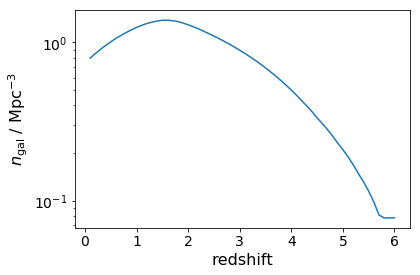

In [14]:
plt.plot(z_gal,n_gal*(1+z_gal)**-3)
#plt.plot(z_gal,n_gal)
plt.ylabel(r"$n_{\rm gal}$ / Mpc$^{-3}$", fontsize=16)
plt.xlabel('redshift', fontsize=16)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)


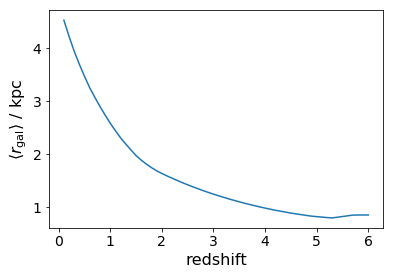

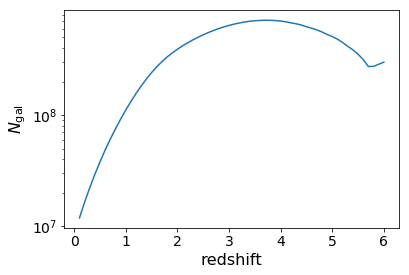

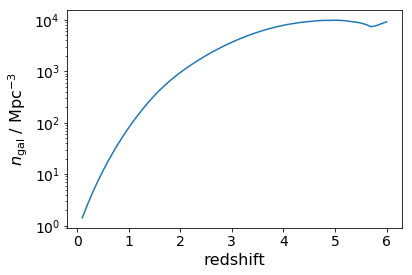

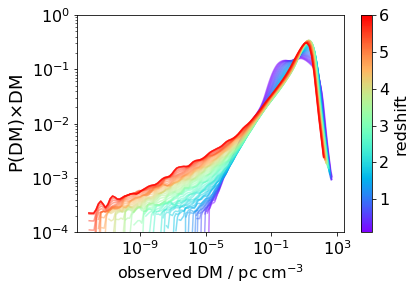

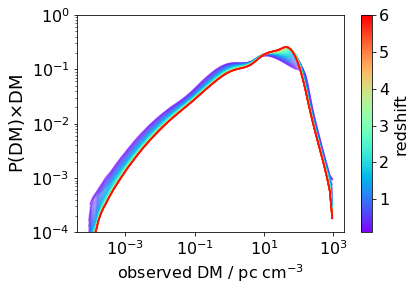

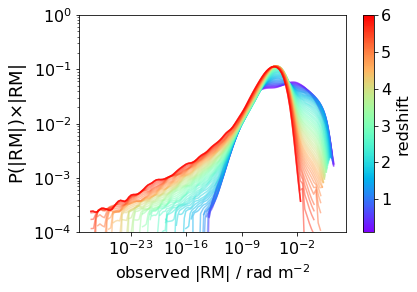

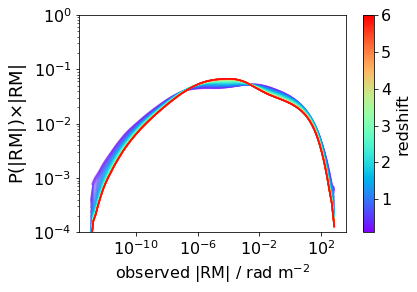

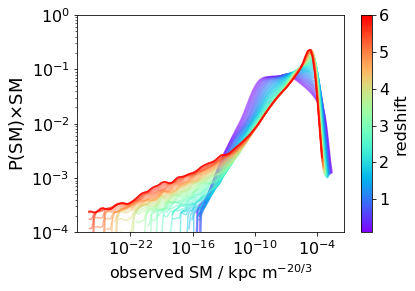

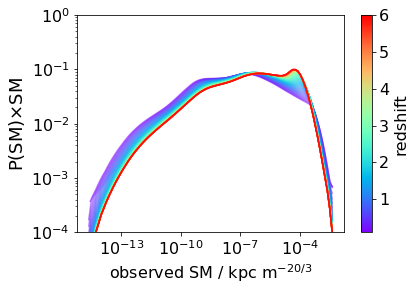

In [9]:
## check results
d = np.genfromtxt(Rodrigues_file_rgal, names=True)
plt.plot( d['redshift'], d['r_gal'])
plt.ylabel(r"$\langle r_{\rm gal} \rangle$ / kpc", fontsize=16)
plt.xlabel('redshift', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show() 
co_vol = 11230468.52 # Mpc3
plt.plot( d['redshift'], d['n_gal']*co_vol)
plt.ylabel(r"$N_{\rm gal}$", fontsize=16)
plt.xlabel('redshift', fontsize=16)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()
plt.plot( d['redshift'], d['n_gal']*(1+d['redshift'])**3)
plt.ylabel(r"$n_{\rm gal}$ / Mpc$^{-3}$", fontsize=16)
plt.xlabel('redshift', fontsize=16)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()



for measure in ['DM','RM','SM']:
    for host in [True, False]:
        PlotLikelihoodEvolution( measure=measure, scenario={'Host' if host else 'Inter':['Rodrigues18']}, colorbar=True, density=True, alpha=0.5 )
        plt.ylim(1e-4,1)
        plt.show()

           #plt.yscale('linear')

### compare with Kierdorf et al.
depreceated for now, as waiting for data of prediction from single galaxy model with comparable global parameters

Text(0.5,1,'M51 observed S-band')

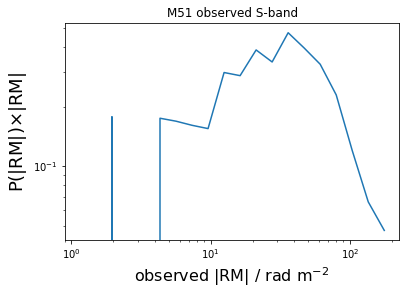

In [22]:
RM_M51 = np.genfromtxt('../../downloads/M51_RM_Sband.txt')
P, x = Histogram( np.abs(RM_M51)[RM_M51 != 0.0], log=True, bins=20, density=True, range=[1,200] )
PlotLikelihood( x, P, measure='RM' )
plt.title( 'M51 observed S-band')

### Intervening Galaxies

We combine the likelihood functions of intervening galaxies $P_{\rm inter}$ at redshift $z$ to likelihood function for contribution of intervening galaxies $P_{\rm Inter}$ of unknown redshift to LoS of source at redshift $z_s$. This is done by adding probabilities of different bins, weighted by the probability to intersect galaxy in that bin, $n_{\rm inter}(z)$. Here we compute that probability as well as the average number of intervening galaxies as function of source redshift
$$
N_{\rm Inter}(z_s) = \int\limits_0^{z_s} \pi r_{\rm gal}^2 n_{\rm gal} \frac{d_H(z)}{1+z} \text{d}z = \int \pi(z) \text{d}z = \sum n_{\rm inter}(z) 
$$
which is used to renormalize $N_{\rm Inter}(z) = \int P_{\rm Inter}(\text{DM}|z) \text{d}\text{DM}$.
$d_H$ is Hubble length.

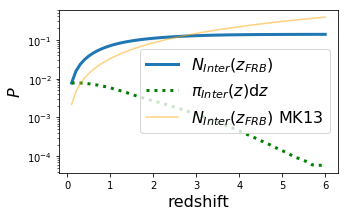

In [13]:
### plot likelihood for galaxies at redshift to intersect LoS, n_inter, which is used to weigh the redshift bins
### as well as expectet number of galaxies in LoS to source, N_inter

fig, ax = plt.subplots( figsize=(5,3) )


model = 'Rodrigues18'

#pi_inter = PriorInter( redshift_bins[-1], model=model )
n_inter = nInter( redshift_bins[-1], model=model )
N_inter = np.cumsum( n_inter)

plt.plot( redshift_bins, N_inter, label=r"$N_{Inter}(z_{FRB})$", lw=3 )
plt.plot( redshift_bins, n_inter, linestyle=':', label=r"$\pi_{Inter}(z)$d$z$", color='green', lw=3 )

model = 'Macquart13'
n_inter = nInter( redshift_bins[-1], model=model )
N_inter = np.cumsum( n_inter)
plt.plot( redshift_bins, N_inter, label=r"$N_{Inter}(z_{FRB})$ MK13", alpha=0.5, color='orange' )

plt.xlabel('redshift', fontsize=16)
plt.ylabel(r"$P$", fontsize=16)
plt.yscale( 'log')
plt.legend( fontsize=16)
AllSidesTicks(ax)


Finally, compute the full likelihood $P_{\rm Inter}$ for contribution of interverning galaxies of unknown type at unknown redshift to measures along LoS to source at redshift $z_s$ by summing the contribution of individual redshifts $P_{\rm inter}$ weighed by the intersection probability $\pi_{\rm inter}$.
$$
P_{\rm Inter} (DM|z_s) = \int P_{\rm inter}(DM|z) \pi_{\rm inter}(z) \text{d}z = \sum P_{\rm inter}( DM|z) n_{\rm inter}(z)
$$

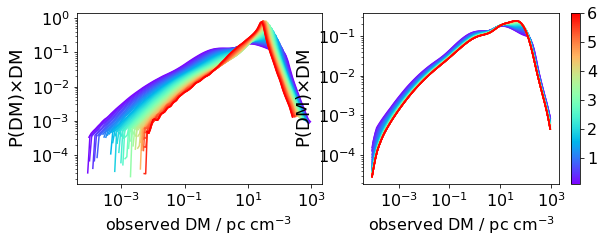

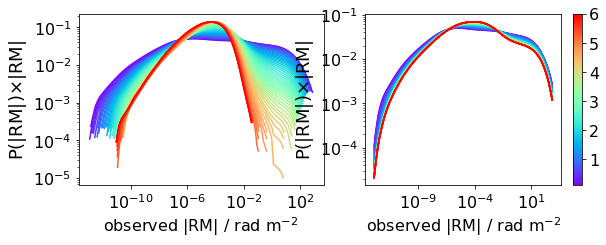

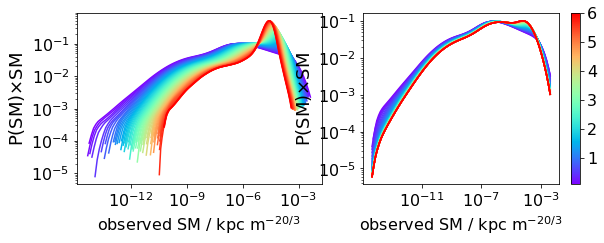

In [14]:
measures = [ 'DM', 'RM', 'SM' ]  ## scattering time needs special treatment in own notebook

fig, axs1 = plt.subplots( 1, 2, figsize=(8,3))
Colorbar(redshift_bins)
fig.tight_layout()
fig, axs2 = plt.subplots( 1, 2, figsize=(8,3))
Colorbar(redshift_bins)
fig.tight_layout()
fig, axs3 = plt.subplots( 1, 2, figsize=(8,3))
Colorbar(redshift_bins)
fig.tight_layout()
axs = [ axs1, axs2, axs3 ]

model='Rodrigues18'

weights = nInter( redshift_bins[-1], model=model )
## redshifts of intervening galaxy chosen in center of bin
redshift_L = redshift_bins - np.diff(redshift_range)/2


for measure, axs in zip( measures, axs ):
    for i_s, (z_s, color) in enumerate( zip( redshift_bins, rainbow( np.linspace(0,1,len(redshift_bins)) ) ) ):
        ## for source redshift
        Ps, xs = [], []
        for i_L , (z_L, color_L) in enumerate( zip( redshift_L[:i_s+1], rainbow( np.linspace(0,1,len(redshift_bins)) ) ) ):
            ### read and collect P_inter(DM|z_L) for all z_L <= z_s
            P, x = GetLikelihood_inter( redshift=redshift_bins[i_L], model=model, measure=measure)
            if i_s == len(redshift_bins) - 1:
                PlotLikelihood( x=x, P=P, measure=measure, color=color_L, ax=axs[0] )
            Ps.append(P)
            xs.append(x)
        ### integrate results for all intervening redshifts, weighing with differential intersection probability
        ### result is renormalized to 1, can be read out renormalized to N_inter with GetLikelihood_Inter( ..., N_inter=True )
        P, x = LikelihoodsAdd( Ps, xs, weights=weights[:i_s+1], renormalize=1 )
        PlotLikelihood( x=x, P=P, measure=measure, color=color, ax=axs[1] )
        Write2h5( filename=likelihood_file_galaxy, datas=[P,x], 
                 keys=[ KeyInter( redshift=z_s, model=model, measure=measure, axis=axis) for axis in ['P','x'] ] 
                )

plt.show()


### test results for fake galaxy model
create fake galaxy results for tests

1.0


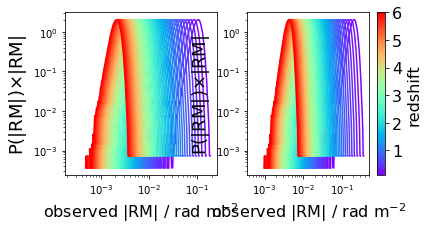

In [12]:
RM_0 = 0.1 # rad m^-2
sigma = 0.2 # log-scaled deviation

#RMs = np.random.lognormal(mean=RM_0, sigma=sigma, size=100000)
RMs = np.random.normal(loc=RM_0, scale=sigma/10, size=100000)


colors = rainbow( np.linspace( 0, 1, len(zs)+1 ) )


fig, axs = plt.subplots( 1, 2, figsize=(6,3))

P, x = Histogram( data=RMs, bins=N_bins, density=True, log=True)
PlotLikelihood( x, P,  measure='RM', color=colors[0], ax=axs[0])
#'''
x_ = x*2  # rough estimate for intervening galaxies
P_ = P/ np.sum( P*np.diff(x_) )
print np.sum( P_*np.diff(x_) )
        
PlotLikelihood( x_, P_,  measure='RM', color=colors[0], ax=axs[1])
#'''
for z, color in zip( zs, colors[1:] ):
    P_ = P*(1+z)**2
    x_ = x/(1+z)**2
    PlotLikelihood( x_, P_,  measure='RM', color=color, ax=axs[0])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyHost( redshift=z, model='Rodrigues18/smd', measure='RM', axis=axis) for axis in ['P','x'] ] )
    x_ *= 2  # rough estimate for intervening galaxies
    P_ /= np.sum( P_*np.diff(x_) )
    if not np.round( np.sum( P_*np.diff(x_) ), 4) == 1.:
        print np.sum( P_*np.diff(x_) )
    PlotLikelihood( x_, P_,  measure='RM', color=color, ax=axs[1])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyInter( redshift=z, model='Rodrigues18/raw', measure='RM', axis=axis) for axis in ['P','x'] ] )
    
#mp = plt.imsave( 'imsave.png', zs.reshape([len(zs),1]), cmap=rainbow )

Colorbar( zs, label='redshift' ) #, position=[0.5,0.15,0.05,0.7] )


1.0


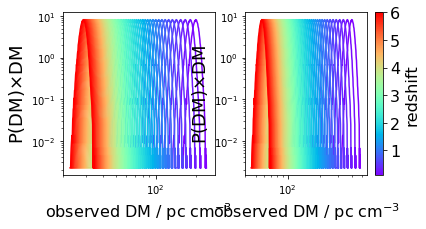

In [13]:
DM_0 = 200 # pc cm^-3
sigma = 10. # log-scaled deviation

DMs = np.random.normal(loc=DM_0, scale=sigma, size=100000)


colors = rainbow( np.linspace( 0, 1, len(zs)+1 ) )


fig, axs = plt.subplots( 1, 2, figsize=(6,3))

P, x = Histogram( data=DMs, bins=N_bins, density=True, log=True)
PlotLikelihood( x, P,  measure='DM', color=colors[0], ax=axs[0])
#'''
x_ = x*2  # rough estimate for intervening galaxies
P_ = P/ np.sum( P*np.diff(x_) )
print np.sum( P_*np.diff(x_) )
        
PlotLikelihood( x_, P_,  measure='DM', color=colors[0], ax=axs[1])
#'''
for z, color in zip( zs, colors[1:] ):
    P_ = P*(1+z)
    x_ = x/(1+z)
    PlotLikelihood( x_, P_,  measure='DM', color=color, ax=axs[0])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyHost( redshift=z, model='Rodrigues18/smd', measure='DM', axis=axis) for axis in ['P','x'] ] )
    x_ *= 2  # rough estimate for intervening galaxies
    P_ /= np.sum( P_*np.diff(x_) )
    if not np.round( np.sum( P_*np.diff(x_) ), 4) == 1.:
        print np.sum( P_*np.diff(x_) )
    PlotLikelihood( x_, P_,  measure='DM', color=color, ax=axs[1])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyInter( redshift=z, model='Rodrigues18/raw', measure='DM', axis=axis) for axis in ['P','x'] ] )
    
#mp = plt.imsave( 'imsave.png', zs.reshape([len(zs),1]), cmap=rainbow )

Colorbar( zs, label='redshift' ) #, position=[0.5,0.15,0.05,0.7] )


1.0


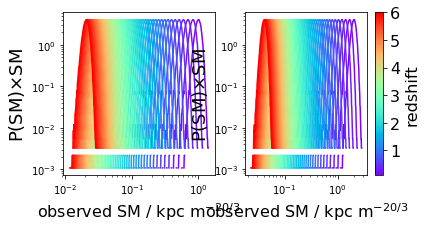

In [14]:
SM_0 = 1 # kpc m^-20/3
sigma = 0.1 # deviation

SMs = np.random.normal(loc=SM_0, scale=sigma, size=100000)


colors = rainbow( np.linspace( 0, 1, len(zs)+1 ) )


fig, axs = plt.subplots( 1, 2, figsize=(6,3))

P, x = Histogram( data=SMs, bins=N_bins, density=True, log=True)
PlotLikelihood( x, P,  measure='SM', color=colors[0], ax=axs[0])
#'''
x_ = x*2  # rough estimate for intervening galaxies
P_ = P/ np.sum( P*np.diff(x_) )
print np.sum( P_*np.diff(x_) )
        
PlotLikelihood( x_, P_,  measure='SM', color=colors[0], ax=axs[1])
#'''
for z, color in zip( zs, colors[1:] ):
    P_ = P*(1+z)**2
    x_ = x/(1+z)**2
    PlotLikelihood( x_, P_,  measure='SM', color=color, ax=axs[0])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyHost( redshift=z, model='Rodrigues18/smd', measure='SM', axis=axis) for axis in ['P','x'] ] )
    x_ *= 2  # rough estimate for intervening galaxies
    P_ /= np.sum( P_*np.diff(x_) )
    if not np.round( np.sum( P_*np.diff(x_) ), 4) == 1.:
        print np.sum( P_*np.diff(x_) )
    PlotLikelihood( x_, P_,  measure='SM', color=color, ax=axs[1])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyInter( redshift=z, model='Rodrigues18/raw', measure='SM', axis=axis) for axis in ['P','x'] ] )
    
#mp = plt.imsave( 'imsave.png', zs.reshape([len(zs),1]), cmap=rainbow )

Colorbar( zs, label='redshift' ) #, position=[0.5,0.15,0.05,0.7] )


1.0


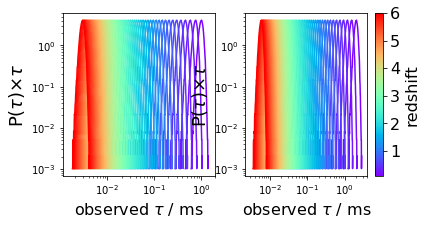

In [15]:
tau_0 = 1 #  ms
sigma = 0.1 # deviation

taus = np.random.normal(loc=tau_0, scale=sigma, size=100000)


colors = rainbow( np.linspace( 0, 1, len(zs)+1 ) )


fig, axs = plt.subplots( 1, 2, figsize=(6,3))

P, x = Histogram( data=taus, bins=N_bins, density=True, log=True)
PlotLikelihood( x, P,  measure='tau', color=colors[0], ax=axs[0])
#'''
x_ = x*2  # rough estimate for intervening galaxies
P_ = P/ np.sum( P*np.diff(x_) )
print np.sum( P_*np.diff(x_) )
        
PlotLikelihood( x_, P_,  measure='tau', color=colors[0], ax=axs[1])
#'''
for z, color in zip( zs, colors[1:] ):
    P_ = P*(1+z)**3
    x_ = x/(1+z)**3
    PlotLikelihood( x_, P_,  measure='tau', color=color, ax=axs[0])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyHost( redshift=z, model='Rodrigues18/smd', measure='tau', axis=axis) for axis in ['P','x'] ] )
    x_ *= 2  # rough estimate for intervening galaxies
    P_ /= np.sum( P_*np.diff(x_) )
    if not np.round( np.sum( P_*np.diff(x_) ), 4) == 1.:
        print np.sum( P_*np.diff(x_) )
    PlotLikelihood( x_, P_,  measure='tau', color=color, ax=axs[1])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyInter( redshift=z, model='Rodrigues18/raw', measure='tau', axis=axis) for axis in ['P','x'] ] )
    
#mp = plt.imsave( 'imsave.png', zs.reshape([len(zs),1]), cmap=rainbow )

Colorbar( zs, label='redshift' ) #, position=[0.5,0.15,0.05,0.7] )


### Compute galaxy number density from galaxy mass function
This is not needed, since all the info is already encoded in results of Rodrigues et al.

In [26]:
def Schechter( M, M_star=1, phi1=1, alpha1=1, phi2=1, alpha2=1):
    return ( phi1 * ( M / M_star )**alpha1 + phi2 * ( M / M_star )**alpha2 ) * np.exp( -M/M_star ) / M_star

In [28]:
## Best fit parameters from Davidzon et al. 2017, Tab. 1, redshifts are extended to z=0 and z=6
parameters = np.genfromtxt( '../COSMOS2015_Schechter_fit.txt', names=True)
parameters['M_star'] = 10.**parameters['M_star']

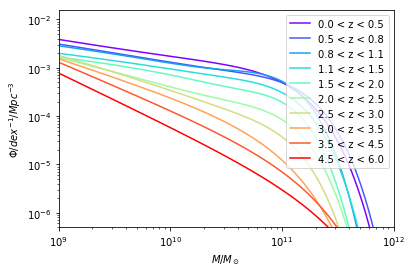

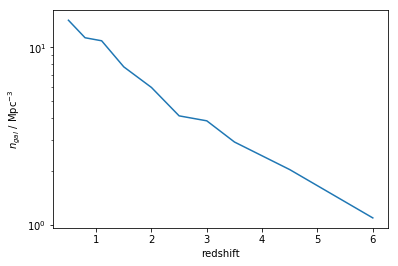

In [29]:
Ms = 10.**np.linspace(9,12,101)
dMs = np.diff(Ms)
n_gal = []
colors = rainbow( np.linspace( 0, 1, len(parameters) ) )
for p, c in zip( parameters, colors ):
    phi = Schechter( Ms, M_star=p['M_star']*1.067, phi1=p['phi1'], alpha1=p['alpha1'], phi2=p['phi2'], alpha2=p['alpha2']) 
    ### correct unit prefactors !!!
    n_gal.append( np.sum( phi[:-1]*dMs ) )
    plt.loglog( Ms[:-1]+dMs/2, phi[:-1]*dMs/110.2, label='%.1f < z < %.1f' % ( p['z0'], p['z1'] ), color=c )
plt.legend()
plt.xlabel('$M/M_\odot$')
plt.ylabel('$\Phi/dex^{-1}/Mpc^{-3}$')
plt.ylim(10.**-6.3, 10.**-1.8)
plt.xlim(1e9, 1e12)
plt.show()

plt.plot( parameters['z1'], n_gal )
plt.ylabel('$n_{gal}$ / Mpc$^{-3}$')
plt.xlabel('redshift')
plt.yscale('log')
plt.show()

In [13]:
len(parameters)


10

In [17]:
import yt
co = yt.utilities.cosmology.Cosmology()
radial_distance = co.comoving_radial_distance